# Prediction with Captions using embeding layer

In [1]:
import pandas as pd
from keras import Sequential
from keras import layers
from keras import regularizers
import numpy as np
from string import punctuation
import pyprind
from collections import Counter
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras import preprocessing

# for reproducability
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)


/home/stone/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# load labels and captions
def read_caps(fname):
    """Load the captions into a dataframe"""
    vn = []
    cap = []
    df = pd.DataFrame();
    with open(fname) as f:
        for line in f:
            pairs = line.split()
            vn.append(pairs[0])
            cap.append(pairs[1])
        df['video']=vn
        df['caption']=cap
    return df

def Get_score(Y_pred,Y_true):
    '''Calculate the Spearmann"s correlation coefficient'''
    Y_pred = np.squeeze(Y_pred)
    Y_true = np.squeeze(Y_true)
    if Y_pred.shape != Y_true.shape:
        print('Input shapes don\'t match!')
    else:
        if len(Y_pred.shape) == 1:
            Res = pd.DataFrame({'Y_true':Y_true,'Y_pred':Y_pred})
            score_mat = Res[['Y_true','Y_pred']].corr(method='spearman',min_periods=1)
            print('The Spearman\'s correlation coefficient is: %.3f' % score_mat.iloc[1][0])
        else:
            for ii in range(Y_pred.shape[1]):
                Get_score(Y_pred[:,ii],Y_true[:,ii])

In [3]:
# load the captions
#cap_path = '/media/win/Users/ecelab-adm/Desktop/DataSet_me18me/me18me-devset/dev-set/dev-set_video-captions.txt'
cap_path = '/media/stone/Data/DataSet_me18me/me18me-devset/dev-set/dev-set_video-captions.txt'
df_cap_train=read_caps(cap_path)
print('train data set shape',df_cap_train.shape)

# load test captions
#cap_path = '/media/win/Users/ecelab-adm/Desktop/DataSet_me18me/test-set/test-set_videos-captions.txt'
cap_path = '/media/stone/Data/DataSet_me18me/testset/test-set_videos-captions.txt'
df_cap_test=read_caps(cap_path)
print('test data set shape',df_cap_test.shape)

df_cap = pd.concat([df_cap_train,df_cap_test],ignore_index=True)
print('shape after concatenation',df_cap.shape)

# load the ground truth values
#label_path = '/media/win/Users/ecelab-adm/Desktop/DataSet_me18me/me18me-devset/dev-set/ground-truth/' 
label_path = '/media/stone/Data/DataSet_me18me/me18me-devset/dev-set/ground-truth/'

labels=pd.read_csv(label_path+'ground-truth_dev-set.csv')

counts = Counter()
# setup prograss tracker
pbar = pyprind.ProgBar(len(df_cap['caption']), title='Counting word occurrences')
for i, cap in enumerate(df_cap['caption']):
    # replace punctuations with space
    # convert words to lower case 
    text = ''.join([c if c not in punctuation else ' ' for c in cap]).lower()
    df_cap.loc[i,'caption'] = text
    pbar.update()
    counts.update(text.split())
    
df_cap.head()

Counting word occurrences


train data set shape (8000, 2)
test data set shape (2000, 2)
shape after concatenation (10000, 2)


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


,video,caption
0,video10.webm,couple relaxing on picnic crane shot
1,video100.webm,cute black and white cats in cage at animal sh...
2,video10000.webm,owl in tree close up
3,video10001.webm,around the house on a laptop
4,video10002.webm,beautiful young girl with apple


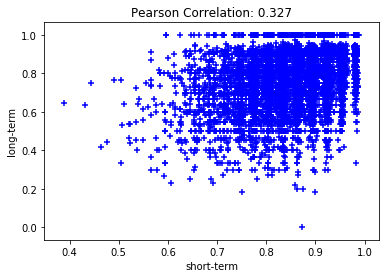

In [4]:
Y = labels[['short-term_memorability','long-term_memorability']].values
plt.figure()
plt.scatter(Y[:,0],Y[:,1],c='blue',marker='+')
plt.xlabel('short-term')
plt.ylabel('long-term')
plt.title('Pearson Correlation: %.3f' % np.corrcoef(Y.T)[0,1])
plt.savefig('correlation_between_mems.eps')

In [5]:
res_len=np.zeros(len(df_cap))
for ii in range(len(df_cap)):
    text = df_cap.caption[ii]
    res_len[ii]=len(text.split())

In [6]:
maxlen = int(max(res_len))

## Vectorize the captions

In [7]:
# build the word index
len_token = len(counts)
tokenizer = Tokenizer(num_words=len_token)
tokenizer.fit_on_texts(list(df_cap.caption.values))
sequences = tokenizer.texts_to_sequences(list(df_cap_train.caption.values))
sequences[:2]

maxlen = 20
X_seq = preprocessing.sequence.pad_sequences(sequences,maxlen=maxlen)
test_sequences = tokenizer.texts_to_sequences(list(df_cap_test.caption.values))
X_test = preprocessing.sequence.pad_sequences(test_sequences,maxlen=maxlen)
X_test.shape

(2000, 20)

In [8]:
Y = labels[['short-term_memorability','long-term_memorability']].values
X = X_seq
X_all = np.concatenate([X,X_test])
X_all.shape

(10000, 20)

In [9]:
X_train, X_val, Y_train, Y_val = train_test_split(X,Y, test_size=0.2, random_state=42)

In [10]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding

In [11]:
Embedding?

In [12]:
model = Sequential()
model.add(Embedding(1+X_all.max(),8,input_length=maxlen))
model.add(Flatten())
model.add(Dense(10,activation='relu',kernel_regularizer=regularizers.l1_l2(l1=0.001,l2=0.002)))
model.add(Dense(2,activation='linear'))

model.compile(optimizer='rmsprop',loss='mae',metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 8)             51096     
_________________________________________________________________
flatten_1 (Flatten)          (None, 160)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1610      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 22        
Total params: 52,728
Trainable params: 52,728
Non-trainable params: 0
_________________________________________________________________


In [13]:
history = model.fit(X_train,Y_train,epochs=20,batch_size=32,validation_data=(X_val,Y_val))

Train on 6400 samples, validate on 1600 samples
Epoch 1/20
6400/6400 [==============================] - 0s 76us/step - loss: 0.3358 - acc: 0.6620 - val_loss: 0.1475 - val_acc: 0.6750
Epoch 2/20
6400/6400 [==============================] - 0s 52us/step - loss: 0.1273 - acc: 0.6950 - val_loss: 0.1202 - val_acc: 0.6956
Epoch 3/20
6400/6400 [==============================] - 0s 57us/step - loss: 0.1089 - acc: 0.7030 - val_loss: 0.1085 - val_acc: 0.6963
Epoch 4/20
6400/6400 [==============================] - 0s 54us/step - loss: 0.0997 - acc: 0.7038 - val_loss: 0.1027 - val_acc: 0.6956
Epoch 5/20
6400/6400 [==============================] - 0s 55us/step - loss: 0.0936 - acc: 0.7039 - val_loss: 0.0989 - val_acc: 0.6963
Epoch 6/20
6400/6400 [==============================] - 0s 53us/step - loss: 0.0892 - acc: 0.7036 - val_loss: 0.0967 - val_acc: 0.6956
Epoch 7/20
6400/6400 [==============================] - 0s 52us/step - loss: 0.0860 - acc: 0.7048 - val_loss: 0.0964 - val_acc: 0.6931
Epoch 8

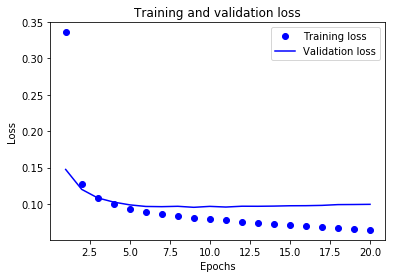

In [14]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(loss)+1)

plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

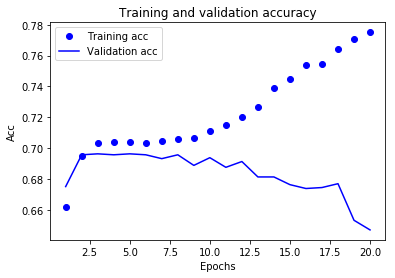

In [15]:
plt.figure()
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()


## Adding Recurrent layer to capture the order of the words

In [16]:
from keras.layers import SimpleRNN, LSTM

model = Sequential()
model.add(Embedding(1+X_all.max(),15,input_length=maxlen))
#model.add(Flatten())
model.add(SimpleRNN(10))
model.add(Dense(10,activation='relu',kernel_regularizer=regularizers.l1_l2(l1=0.001,l2=0.004)))
model.add(Dense(2,activation='linear'))

model.compile(optimizer='rmsprop',loss='mae',metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 20, 15)            95805     
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 10)                260       
_________________________________________________________________
dense_3 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 22        
Total params: 96,197
Trainable params: 96,197
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.fit?

In [18]:
history = model.fit(X_train,Y_train,epochs=3,batch_size=20,validation_data=(X_val,Y_val))

Train on 6400 samples, validate on 1600 samples
Epoch 1/3
6400/6400 [==============================] - 2s 358us/step - loss: 0.1751 - acc: 0.7019 - val_loss: 0.1277 - val_acc: 0.6956
Epoch 2/3
6400/6400 [==============================] - 2s 309us/step - loss: 0.1157 - acc: 0.7033 - val_loss: 0.1151 - val_acc: 0.6956
Epoch 3/3
6400/6400 [==============================] - 2s 305us/step - loss: 0.1039 - acc: 0.7047 - val_loss: 0.1115 - val_acc: 0.6687


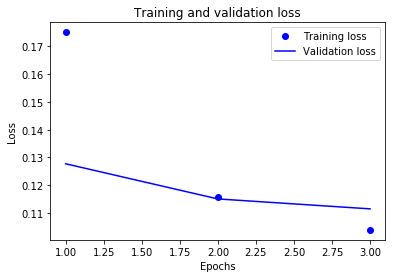

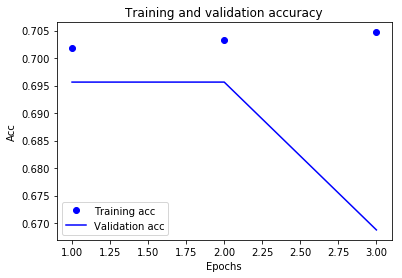

In [19]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(loss)+1)

plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


plt.figure()
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

### Visualizing training and validating results

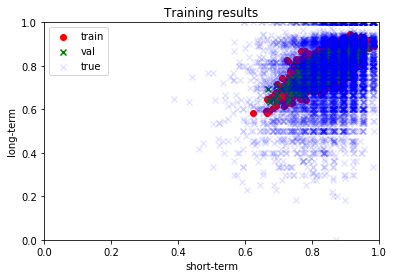

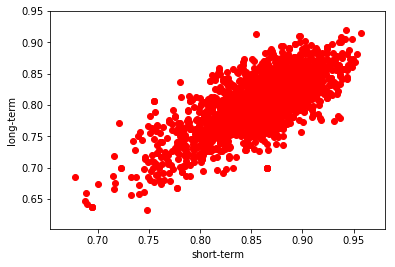

In [20]:
Y_pred_train = model.predict(X_train)
Y_pred_val = model.predict(X_val)

if len(Y.shape) == 2:
    plt.figure()
    plt.scatter(Y_pred_train[:,0],Y_pred_train[:,1],marker='o',c='r',label='train')
    plt.scatter(Y_pred_val[:,0],Y_pred_val[:,1],marker='x',c='g',label='val')
    plt.scatter(Y[:,0],Y[:,1],marker='x',c='b',label='true',alpha=0.1)
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.legend()
    plt.xlabel('short-term')
    plt.ylabel('long-term')
    plt.title('Training results')
    plt.show()
    
    # plot testing results
    Y_pred = model.predict(X_test[:,:],batch_size=32)
    plt.figure()
    plt.scatter(Y_pred[:,0],Y_pred[:,1],marker='o',c='r')
    plt.xlabel('short-term')
    plt.ylabel('long-term')
    plt.show()
    
else:
    plt.figure()
    plt.scatter(Y_pred_train,Y_train,marker='o',c='r',label='train')
    plt.scatter(Y_pred_val,Y_val,marker='x',c='g',label='val')
    #plt.scatter(Y[:,0],Y[:,1],marker='x',c='b',label='true',alpha=0.1)
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.legend()
    plt.xlabel('true')
    plt.ylabel('pred')
    plt.title('Training results [short-term]')
    plt.show()

In [21]:
print('='*20)
print('Training Scores')
Get_score(Y_pred_train,Y_train)
print('='*20)
print('Evaluation Scores')
Get_score(Y_pred_val,Y_val)

Training Scores
The Spearman's correlation coefficient is: 0.643
The Spearman's correlation coefficient is: 0.490
Evaluation Scores
The Spearman's correlation coefficient is: 0.301
The Spearman's correlation coefficient is: 0.133


# Generating test results

In [22]:
Y_pred = model.predict(X_test[:,:],batch_size=32)

In [23]:
Y_pred

array([[0.85131794, 0.80560863],
       [0.9039682 , 0.85529983],
       [0.8351432 , 0.82131696],
       ...,
       [0.85418   , 0.8361924 ],
       [0.8666207 , 0.78552234],
       [0.8586459 , 0.752389  ]], dtype=float32)

In [24]:
Y_pred.min(axis=0)

array([0.67778796, 0.6320367 ], dtype=float32)

In [25]:
Y_pred.max(axis=0)

array([0.9571055 , 0.91991913], dtype=float32)

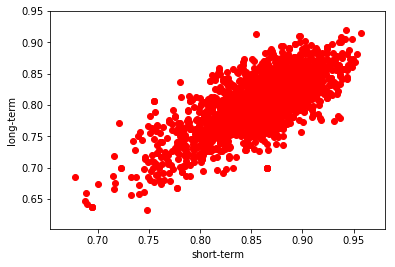

In [26]:
plt.figure()
plt.scatter(Y_pred[:,0],Y_pred[:,1],marker='o',c='r')
plt.xlabel('short-term')
plt.ylabel('long-term')
plt.savefig('NN+captions.eps')

In [27]:
df_cap_test['short-term'] = Y_pred[:,0]
df_cap_test['long-term'] = Y_pred[:,1]
df_cap_test['confidence_interval'] = 0 # not meaningful, this is required but not used for performance evaluation

In [28]:
df_cap_test.head()

,video,caption,short-term,long-term,confidence_interval
0,video1.webm,snow-and-string-lights,0.851318,0.805609,0
1,video1000.webm,clown-fish-swimming-by-rocks-and-coral,0.903968,0.855300,0
2,video1002.webm,cook-preparing-traditional-asian-street-food-m...,0.835143,0.821317,0
3,video1008.webm,beautiful-girl-running-on-sunlit-wheat-field-s...,0.923820,0.811554,0
4,video1010.webm,piece-of-space-shuttle-breaking-off-and-earth-...,0.814796,0.773031,0


In [29]:
res = df_cap_test[['video','short-term','confidence_interval']]
run_name = 'me18in_TheHuskies_shortterm_run4-NN_caps.csv'
res.to_csv(path_or_buf=run_name,sep=',',header=False,index=False)

res1 = df_cap_test[['video','long-term','confidence_interval']]
run_name1 = 'me18in_TheHuskies_longterm_run4-NN_caps.csv'
res1.to_csv(path_or_buf=run_name1,sep=',',header=False,index=False)

## Visualze the model

In [30]:
from keras.utils import plot_model
import pydot

In [31]:
plot_model(model, to_file='model.png',show_shapes=True,rankdir='LR',show_layer_names=False)